In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
train_path = os.path.join('datasets', 'titanic', 'train.csv')
test_path = os.path.join('datasets', 'titanic', 'test.csv')

train_df = pd.read_csv(train_path, index_col='PassengerId')
test_df = pd.read_csv(test_path, index_col='PassengerId')

print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

train_df.head()

Train size:  (891, 11)
Test size:  (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


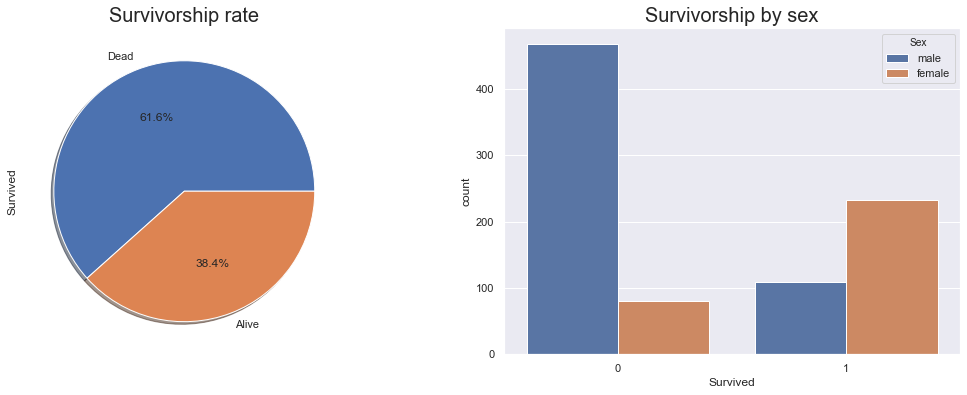

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
train_df['Survived'].value_counts().plot.pie(shadow=True, labels=['Dead', 'Alive'], autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('Survivorship rate', fontsize=20)

sns.countplot(x='Survived', hue='Sex', data=train_df, ax=axes[1])
axes[1].set_title('Survivorship by sex', fontsize=20);

Unfortunately most people died. Out of 891 people in train data 61.6% people died. On titanic cruise there were more men than women. Suprisingly most people who survived were women. It shows that women had a priority during rescue. There were real gentlemen.

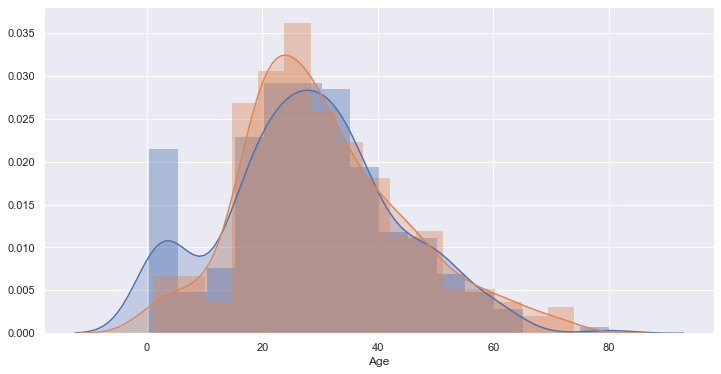

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

kde_kwargs=dict(hist_kws=dict(edgecolor='none'),
                kde_kws={"shade": True})

age_alive = train_df.loc[train_df['Survived'] == 1]
age_dead = train_df.loc[train_df['Survived'] == 0]

sns.distplot(age_alive['Age'], label='Alive', ax=ax, **kde_kwargs)
sns.distplot(age_dead['Age'], label='Dead', ax=ax, **kde_kwargs)

Children first!!! It is clear that most of especially young people survived. Most of passangers where in their 20s

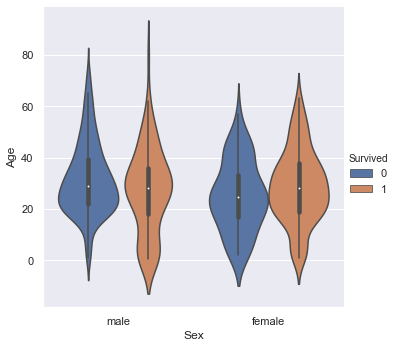

In [6]:
sns.catplot(y='Age', x='Sex', hue='Survived', data=train_df, kind='violin')

We can see the relationship between Sex, Age and Survivorship in the same time. We can see that especially young man died. It is not true for women.

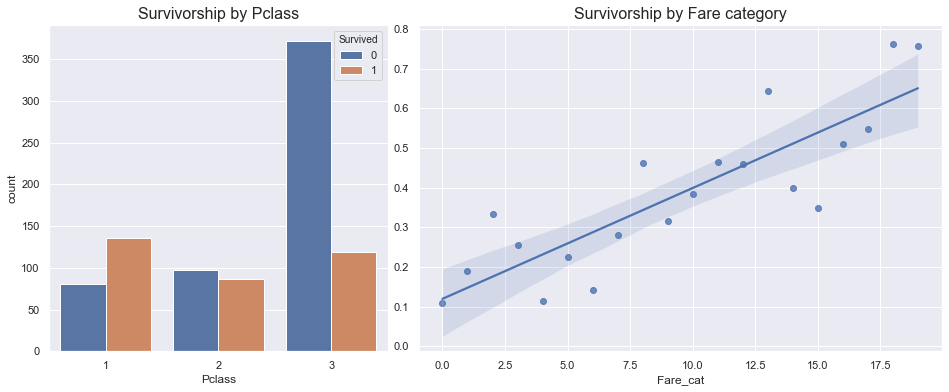

In [7]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(1, 5)

ax1 = fig.add_subplot(grid[0, 0:2])
ax2 = fig.add_subplot(grid[0, 2:])

sns.countplot(x='Pclass', hue='Survived', data=train_df, ax=ax1)
ax1.set_title('Survivorship by Pclass', fontsize=16)

train_df['Fare_cat'] = pd.qcut(train_df['Fare'], q=20, labels=False)
temp = train_df.groupby('Fare_cat')['Survived'].mean()
sns.regplot(x=temp.index, y=temp.values, ax=ax2)
ax2.set_title('Survivorship by Fare category', fontsize=16);

During the cruise it was better to be richer than poorer. It seems that people who decieded to pay more the the cruise had more chances to survive.

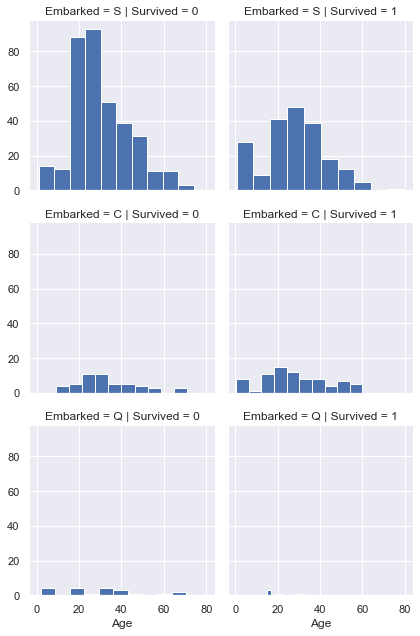

In [8]:
grid = sns.FacetGrid(data=train_df, row='Embarked', col='Survived')
grid.map(plt.hist, 'Age')

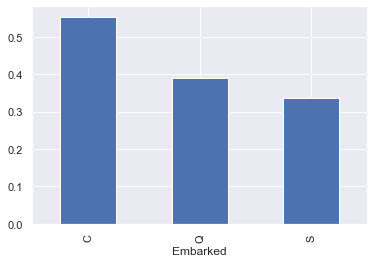

In [9]:
temp = train_df.groupby('Embarked')['Survived'].mean()
temp.plot(kind='bar')

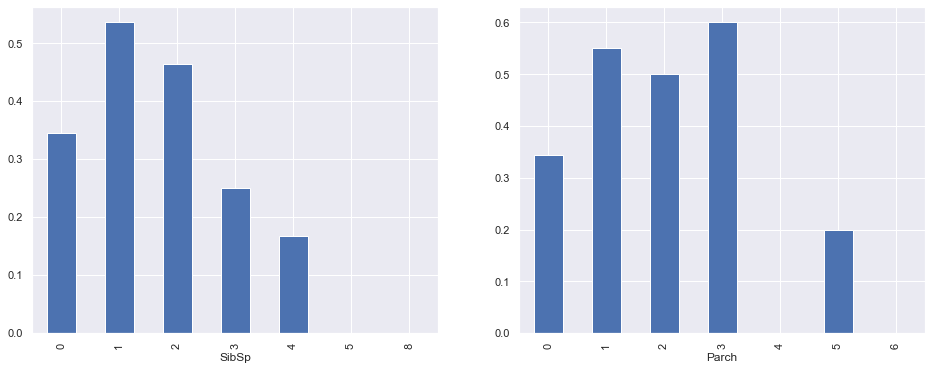

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
temp = train_df.groupby('SibSp')['Survived'].mean()
temp.plot(kind='bar', ax=axes[0])

temp = train_df.groupby('Parch')['Survived'].mean()
temp.plot(kind='bar', ax=axes[1])

In [26]:
titles = ['Mr', 'Miss', 'Mrs', 'Lady']
train_df['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [29]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,17
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,16
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,5


In [53]:
from sklearn.impute import SimpleImputer 
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex', 'Embarked']

In [73]:
num_imputer = SimpleImputer(strategy='mean')
num_df = train_df[num_cols]
num_df = num_imputer.fit_transform(num_df)
num_df = pd.DataFrame(num_df, columns=num_cols)

In [74]:
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_df = train_df[cat_cols]
cat_df = cat_imputer.fit_transform(cat_df)
cat_df = pd.DataFrame(cat_df, columns=cat_cols)
cat_df = pd.get_dummies(cat_df)
result = num_df.join(cat_df)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [82]:
model = RandomForestClassifier()
X = result.values
Y = train_df['Survived'].values
scores = cross_val_score(model, X, Y, cv=5)

In [83]:
scores.mean()

0.8070052099679869